<a href="https://colab.research.google.com/github/afrojaakter/Pattern-Recognition/blob/main/KalmanFilter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install control

     |████████████████████████████████| 348kB 5.3MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344920 sha256=d6113ab8d088fc0c91793e8654e32e1c65980509f609e81a4bbee98f926dbe06
  Stored in directory: /root/.cache/pip/wheels/35/be/ee/081b68ca3e4b2d253fba2f7f7e51960373903fb7b6d13c5532
Successfully built control


In [ ]:
!pip install slycot

     |████████████████████████████████| 1.6MB 4.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417831 sha256=7a6edbb47f4dc5df8be5191650ab556608d8693accb5a4ddbdfeb8a630cc4a70
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot


###Kalman Filter


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
import slycot
from scipy import integrate
from scipy.linalg import schur
# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})

Observability matrix,

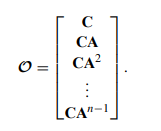

If observability matrix is full rank then the linear system is observable, i.e with a single measurement we can back out all the other variables in time and use that estimated state for full state feedback control.


In [ ]:
m = 1
M = 5
L = 2
g = -10
d = 1

b = -1 # pendulum down (b = -1)

#Linearized dynamics
A = np.array([[0,1,0,0],\
              [0,-d/M,b*m*g/M,0],\
              [0,0,0,1],\
              [0,-b*d/(M*L),-b*(m+M)*g/(M*L),0]])
#Actuator input
B = np.array([0,1/M,0,b/(M*L)]).reshape((4,1))

#mesuare just x position of [x, x', theta, thera']
C = np.array([1,0,0,0]) # measure cart position, x, 

print('Observability matrix rank: {}'.format(np.linalg.matrix_rank(obsv(A,C))))


Observability matrix rank: 4


In [ ]:
#Observable matrix and it's determinant 
obsv(A,C), np.linalg.det(obsv(A,C))

(matrix([[ 1.  ,  0.  ,  0.  ,  0.  ],
         [ 0.  ,  1.  ,  0.  ,  0.  ],
         [ 0.  , -0.2 ,  2.  ,  0.  ],
         [ 0.  ,  0.04, -0.4 ,  2.  ]]), 4.0)

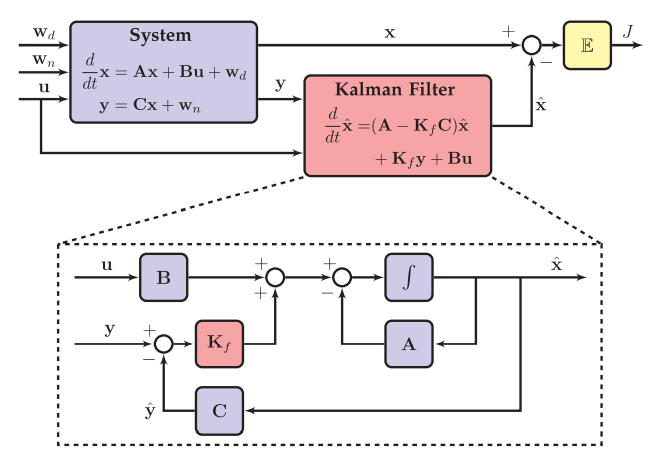

In [ ]:
# Kalman estimator design

def lqe(a,g,c,q,r):
    r = np.atleast_2d(r)
    nn = np.zeros((q.shape[0],len(r)))
    qg = g @ q @ g.T
    ng = g @ nn
    
    qg = (qg + qg.T)/2
    r = (r + r.T)/2
    u,t = schur(r)
    
    t = np.real(np.diag(t))
    
    if np.min(t) <= 0:
        print('Error: covariance matrix must be positive definite')
    else:
        Nr = (ng@u)*np.diag(np.power(np.sqrt(t),-1))
        Qr = qg - Nr @ Nr.T
        if np.min(np.real(np.linalg.eig(Qr)[0])) < -(10**3)*np.finfo(float).eps:
            print('Warning: The matrix [G*Q*G'' G*N;N''*G'' R] should be nonnegative definite')
    c = np.diag(c)
    r = np.squeeze(r)
    (p,e,k) = care(a.T,c.T,qg)#,R=r,S=ng)
    l = k[0,:]
    
    return (l,p,e)

In [ ]:
D = np.zeros((C.shape[0],B.shape[1]))
## Specify disturbance and noise magnitude
Vd = np.eye(4)  # distrubance covariance
Vn = 1          # noise covariance

# Build Kalman filter
Kf, P, E = lqe(A,np.eye(4),C,Vd,Vn)

In [ ]:
## Augment system with additional inputs
Baug = np.concatenate((B, np.eye(4),np.zeros_like(B)),axis=1) # [u I*wd 0*wn]
Daug = np.array([0,0,0,0,0,1]) # D matrix passes noise through

sysC = ss(A,Baug,C,Daug) # Single-measurement system

# "True" system w/ full-state output, disturbance, no noise
sysTruth = ss(A,Baug,np.eye(4),np.zeros((4,Baug.shape[1])))

BKf = np.concatenate((B,np.atleast_2d(Kf).T),axis=1)
#state space((A - K_fC), [B Kf], [d, v])
sysKF = ss(A-np.outer(Kf,C),BKf,np.eye(4),np.zeros_like(BKf))

In [ ]:
## Estimate linearized system in "down" position (Gantry crane)
dt = 0.01
t = np.arange(0,50,dt)

uDIST = np.sqrt(Vd) @ np.random.randn(4,len(t)) # random disturbance
uNOISE = np.sqrt(Vn) * np.random.randn(len(t))    # random noise
u = np.zeros_like(t)
u[100] = 20/dt   # positive impulse
u[1500] = -20/dt # negative impulse

# input w/ disturbance and noise:
uAUG = np.concatenate((u.reshape((1,len(u))),uDIST,uNOISE.reshape((1,len(uNOISE))))).T
#lsim: Simulate output of a continuous-time linear system
y,t,_ = lsim(sysC,uAUG,t)                      # noisy measurement
xtrue,t,_ = lsim(sysTruth,uAUG,t)              # true state
xhat,t,_ = lsim(sysKF,np.concatenate((u.reshape(len(u),1),y), axis = 1),t) # state estimate

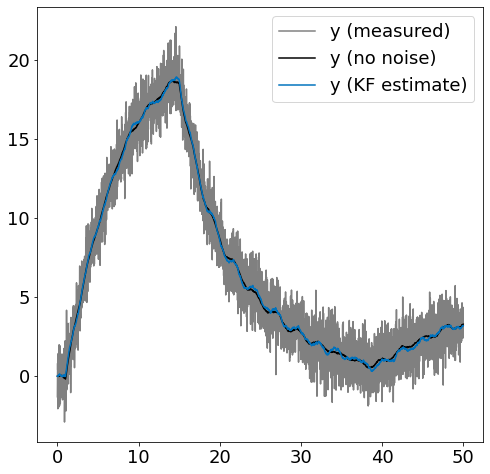

In [ ]:
plt.plot(t,y,color=(0.5,0.5,0.5),label='y (measured)')
plt.plot(t,xtrue[:,0],color='k',label='y (no noise)')
plt.plot(t,xhat[:,0],color=(0,0.447,0.741),label='y (KF estimate)')
plt.legend()
plt.show()

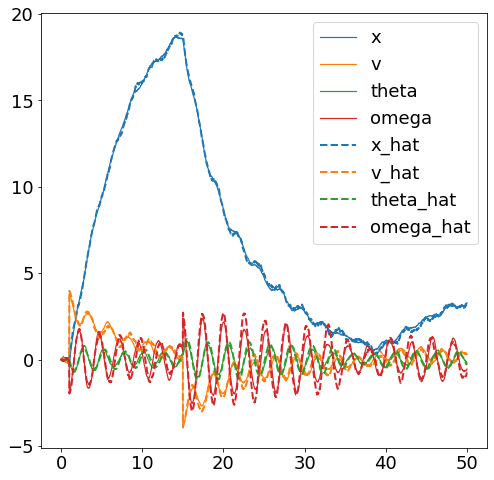

In [ ]:
x_labels = ('x','v','theta','omega')
[plt.plot(t,xtrue[:,k],linewidth=1.2,label=x_labels[k]) for k in range(4)]
plt.gca().set_prop_cycle(None) # reset color cycle
[plt.plot(t,xhat[:,k],'--',linewidth=2,label=x_labels[k]+'_hat') for k in range(4)]
plt.legend()
plt.show()